# Esfandiar Kiani

## Deep Learning - HM01 - Part 2.1 (Classification From Scratch)

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Hyperparameters

In [2]:
FILE_PATH = "D:/M.A/T2/Deep Learning/Assignments/HM1 - Es.Kiani - 40311614/Wine.xlsx"
TRAIN_TEST_RATIO = 0.75
HIDDEN_NEURONS_1 = 64
HIDDEN_NEURONS_2 = 32
HIDDEN_NEURONS_3 = 16
ETA_1 = 0.05
ETA_2 = 0.04
ETA_3 = 0.03
ETA_4 = 0.02
EPOCHS = 50
ACTIVATION_1 = "sigmoid"
ACTIVATION_2 = "sigmoid"
ACTIVATION_3 = "sigmoid"
TRAIN_BIAS = True
SEED = 13

### Activation functions

In [3]:
def pureline(x): return x
def pureline_derivative(x): return np.ones_like(x)
def relu(x): return np.maximum(0, x)
def relu_derivative(x): return np.where(x > 0, 1, 0)
def leaky_relu(x): alpha = 0.01; return np.maximum(alpha * x, x)
def leaky_relu_derivative(x): alpha = 0.01; return np.where(x < 0, alpha, 1)
def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x): return sigmoid(x) * (1 - sigmoid(x))
def tansig(x): return np.tanh(x)
def tansig_derivative(x): return 1 - np.square(tansig(x))
def softmax(x): exp_x = np.exp(x - np.max(x)); return exp_x / np.sum(exp_x)
def softmax_derivative(x): 
    softmax_values = softmax(x).reshape(-1,1)
    return np.diag(softmax_values.flatten()) - np.dot(softmax_values, softmax_values.T)

In [4]:
def get_activation_function(name):
    if name == "pureline": return pureline, pureline_derivative
    elif name == "relu": return relu, relu_derivative
    elif name == "leaky relu" or name == "leaky_relu" : return leaky_relu, leaky_relu_derivative
    elif name == "sigmoid": return sigmoid, sigmoid_derivative
    elif name == "tansig": return tansig, tansig_derivative
    elif name == "softmax": return softmax, softmax_derivative
    else: raise ValueError("Invalid activation function name")

### Loss functions

In [5]:
def cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred + epsilon))

def cross_entropy_derivative(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -y_true / y_pred

### Other Functions

In [6]:
def split_train_test_data(X, Y, train_ratio):
    split_index = int(len(X) * train_ratio)
    X_train = X[:split_index]
    Y_train = Y[:split_index]
    X_test = X[split_index:]
    Y_test = Y[split_index:]
    return X_train, Y_train, X_test, Y_test

def normalize(matrix):
    normalized_matrix = []
    for col in matrix.T:
        min_val = min(col)
        max_val = max(col)
        normalized_col = [(x - min_val) / (max_val - min_val) if max_val != min_val else x for x in col]
        normalized_matrix.append(normalized_col)
    return np.array(normalized_matrix).T


def initialize_Layer(previous_layer, next_layer, activation_function):
    W = np.random.uniform(-1, 1, size=(next_layer, previous_layer))
    Wb = np.ones((next_layer, 1))
    NET = np.zeros((next_layer, 1))
    F, dF = get_activation_function(activation_function)
    O = np.zeros((next_layer, 1))
    return W, Wb, NET, F, dF, O

def plot_loss(epoch, loss_train, loss_test):
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.plot(loss_train[:epoch+1], color='blue')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(loss_test[:epoch+1], color='blue')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.pause(0.1)

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(y_true_labels)):
        cm[y_true_labels[i], y_pred_labels[i]] += 1
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            num_text = format(cm[i, j], 'd')
            perc_text = format((cm[i, j] / np.sum(cm[i])) * 100, '.2f') + "%"
            plt.text(j, i, f"{num_text}\n({perc_text})",
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Set random seed

In [7]:
np.random.seed(SEED)

### Load data

In [8]:
data = pd.read_excel(FILE_PATH, header=None)

In [9]:
num_classes = data.iloc[:, -1].nunique()
data_shuffled = data.sample(n=len(data))
X = data_shuffled.iloc[:, :-1].values
Y = data_shuffled.iloc[:, -1].values.reshape(-1,1)

### Split data

In [10]:
X_train_raw, Y_train, X_test_raw, Y_test = split_train_test_data(X, Y, TRAIN_TEST_RATIO)

In [11]:
# Y_train

### Normalize data

In [12]:
X_train = normalize(X_train_raw)
X_test = normalize(X_test_raw)

### One-Hot Encoding

In [13]:
Y_train = Y_train.astype(int) - 1
Y_test = Y_test.astype(int) - 1
Y_train_one_hot = np.eye(num_classes)[Y_train.flatten()]
Y_test_one_hot = np.eye(num_classes)[Y_test.flatten()]

In [14]:
# Y_train

### Initialize weights 

In [15]:
input_size = X.shape[1]
N0 = input_size
N1 = HIDDEN_NEURONS_1
N2 = HIDDEN_NEURONS_2
N3 = HIDDEN_NEURONS_3
N4 = num_classes

W1, b1, NET1, F1, dF1, O1 = initialize_Layer(N0, N1, ACTIVATION_1)
W2, b2, NET2, F2, dF2, O2 = initialize_Layer(N1, N2, ACTIVATION_2)
W3, b3, NET3, F3, dF3, O3 = initialize_Layer(N2, N3, ACTIVATION_3)
W4, b4, NET4, F4, dF4, O4 = initialize_Layer(N3, N4, "leaky_relu")

if not TRAIN_BIAS:
    b1 = np.zeros_like(b1)
    b2 = np.zeros_like(b2)
    b3 = np.zeros_like(b3)
    b4 = np.zeros_like(b4)

### Training

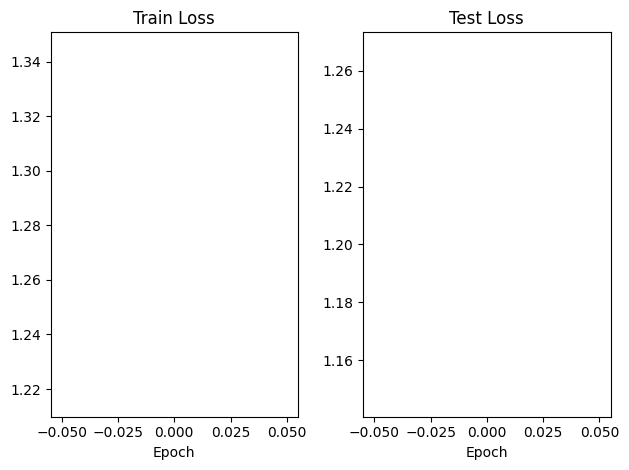

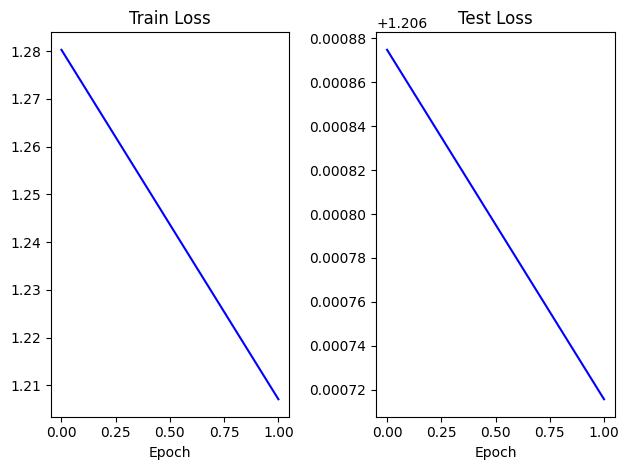

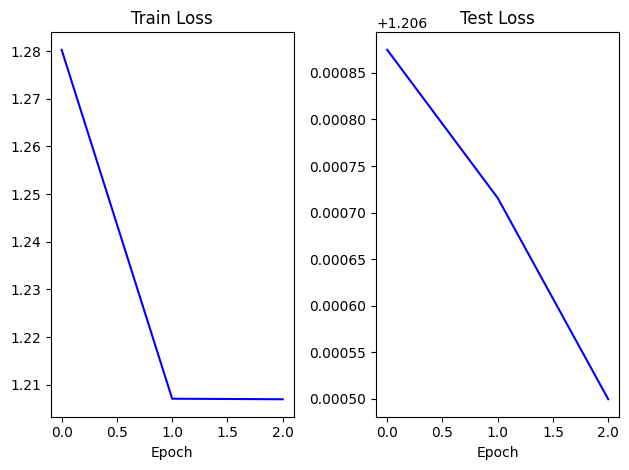

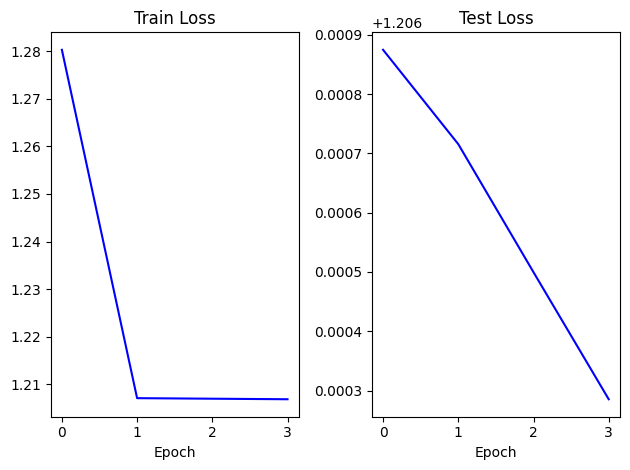

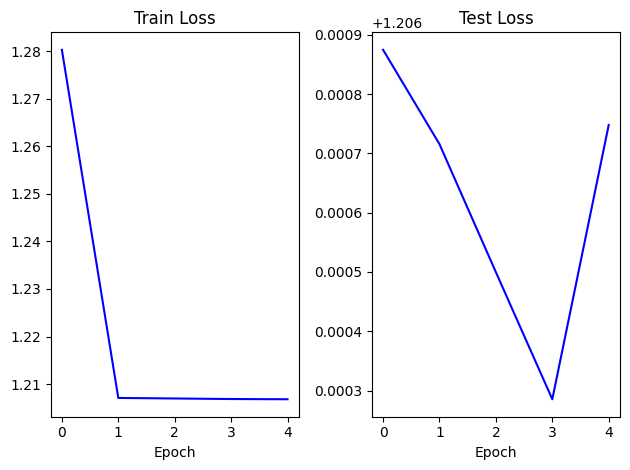

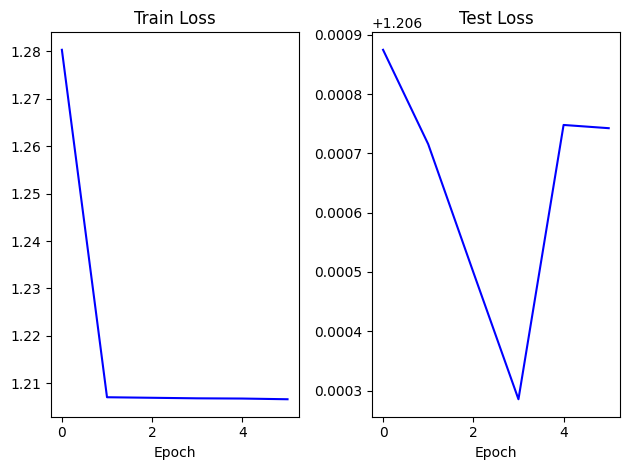

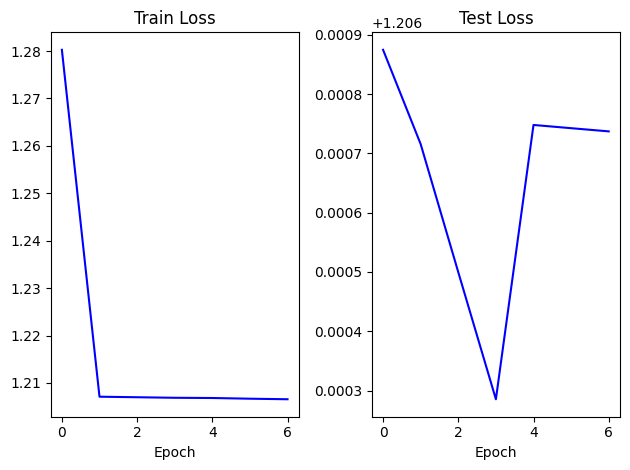

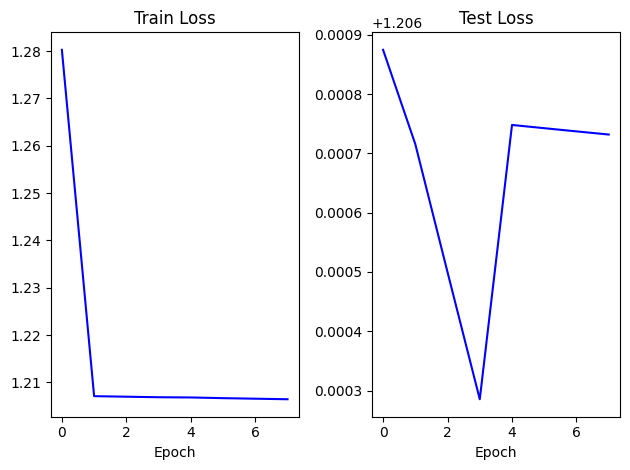

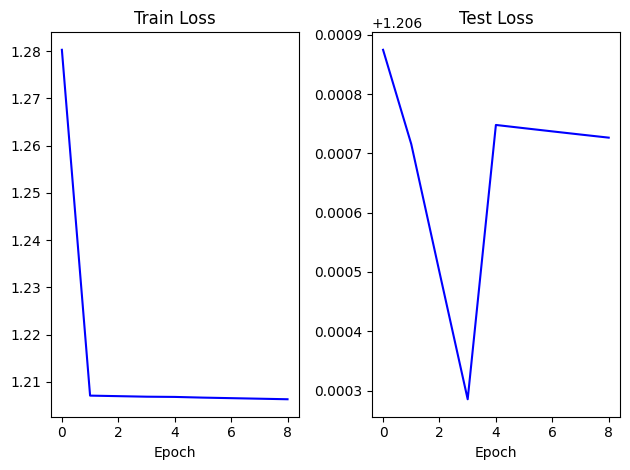

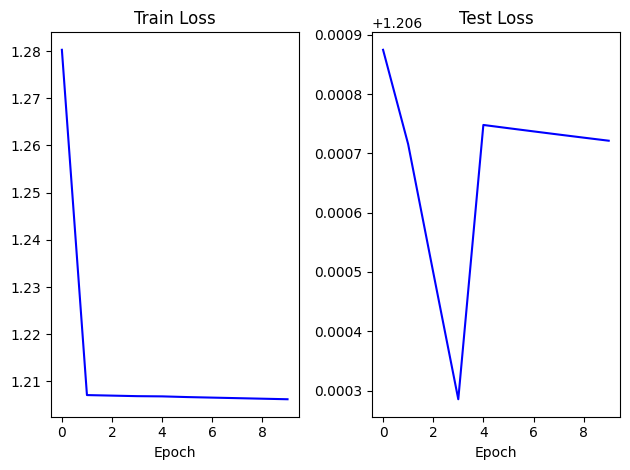

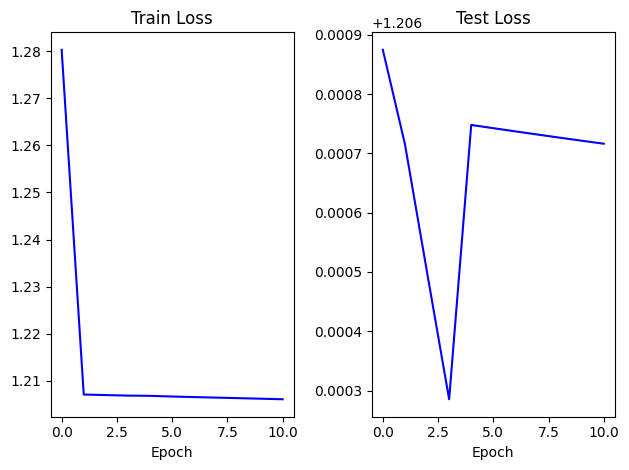

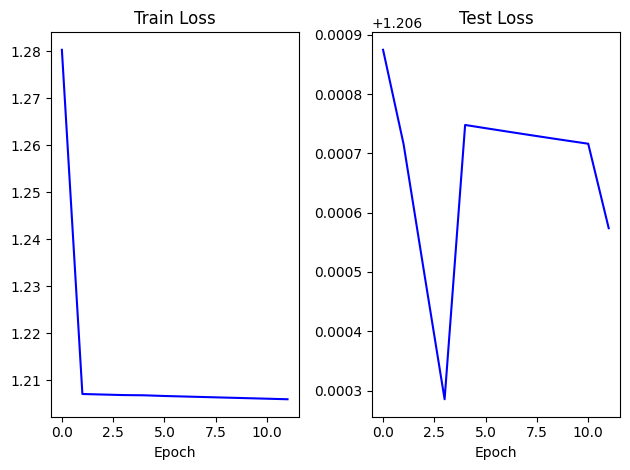

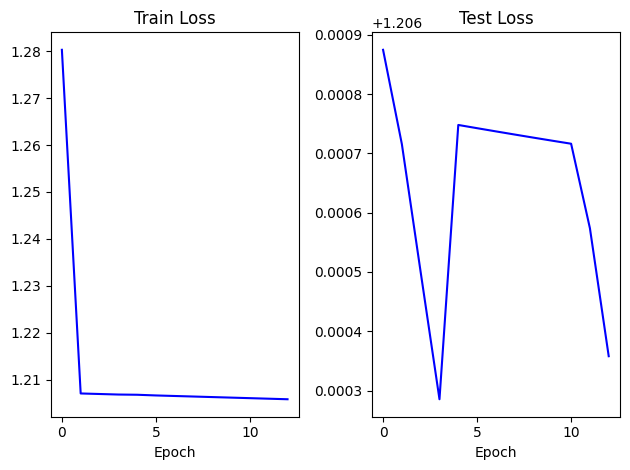

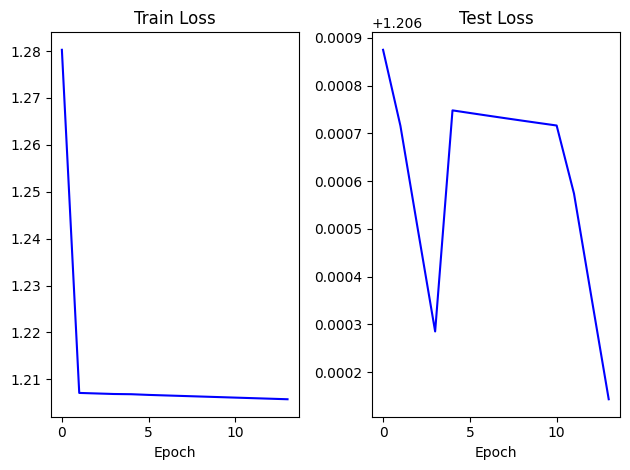

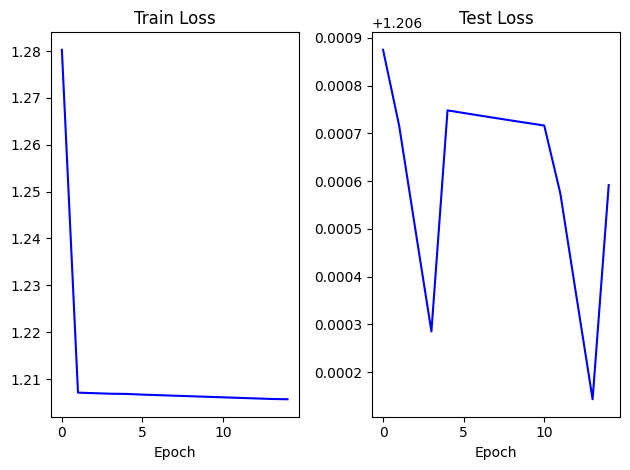

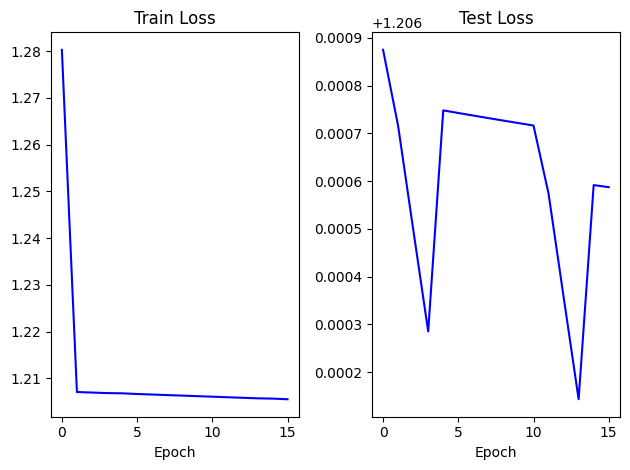

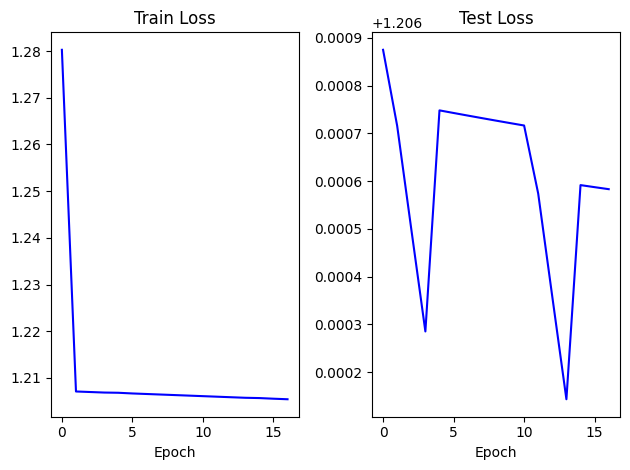

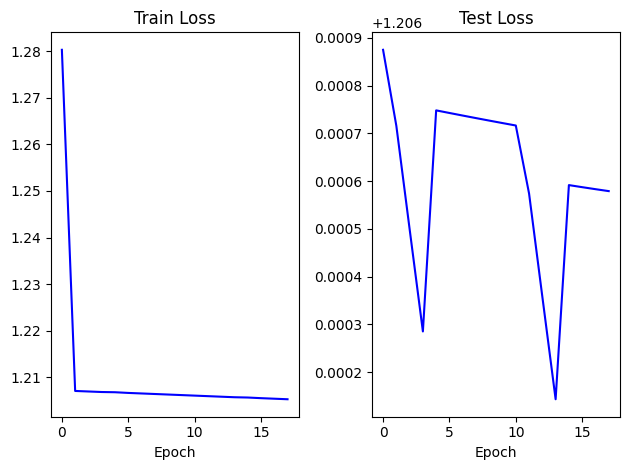

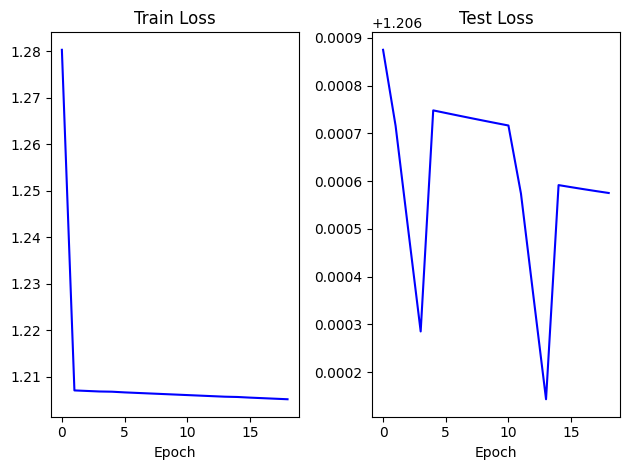

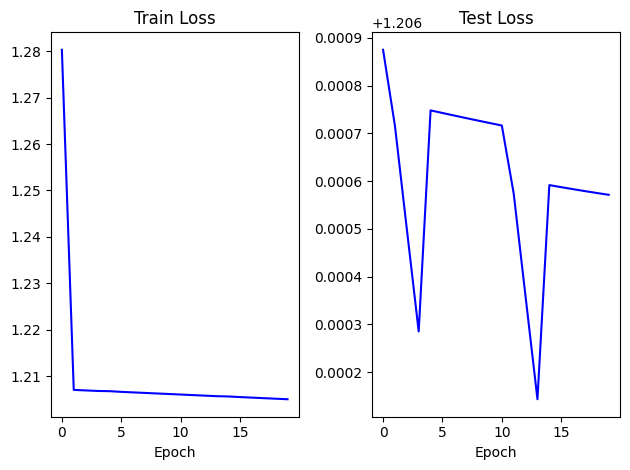

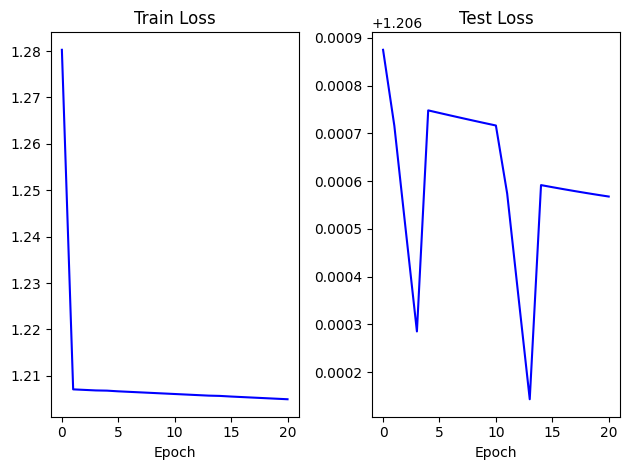

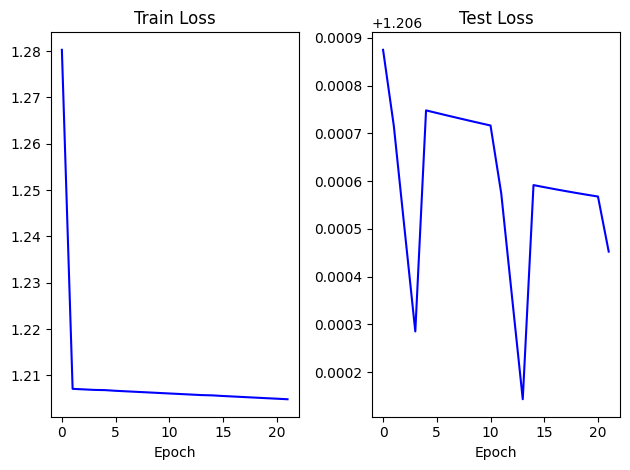

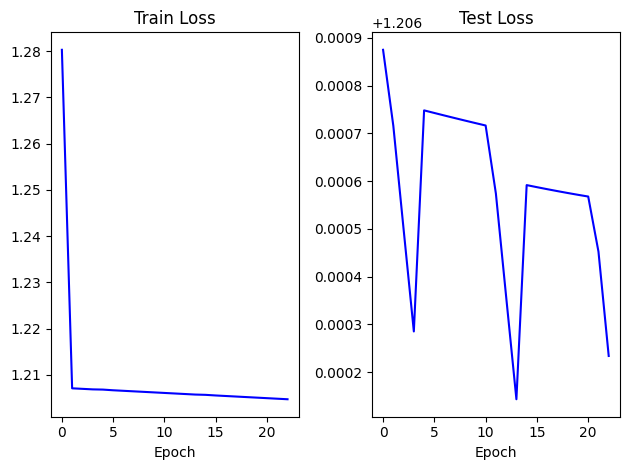

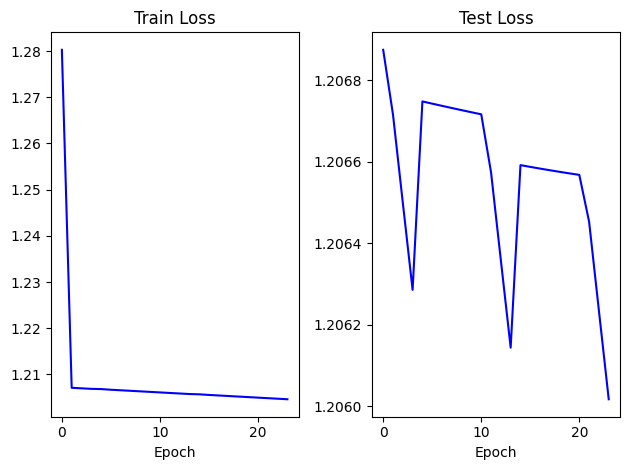

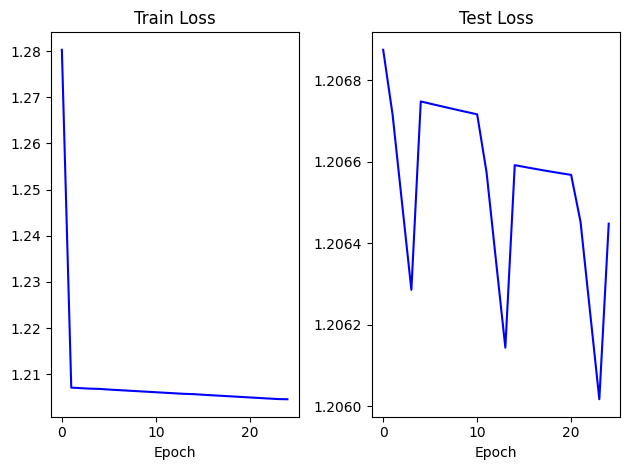

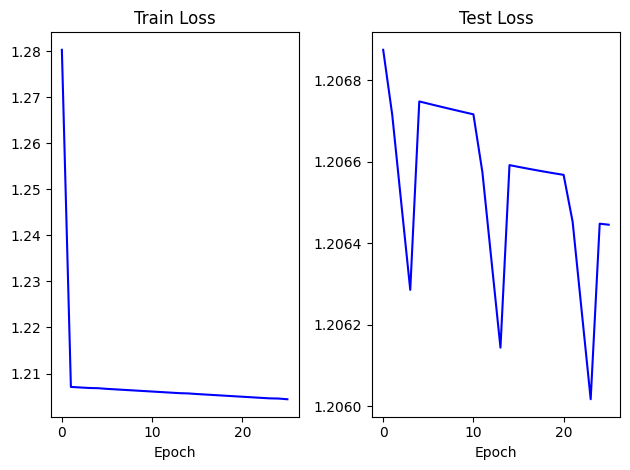

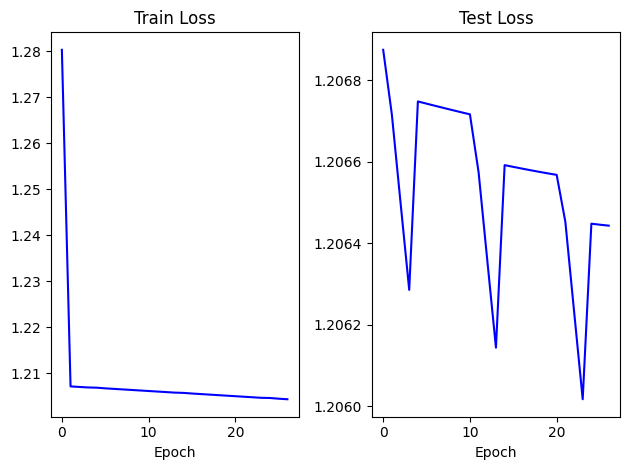

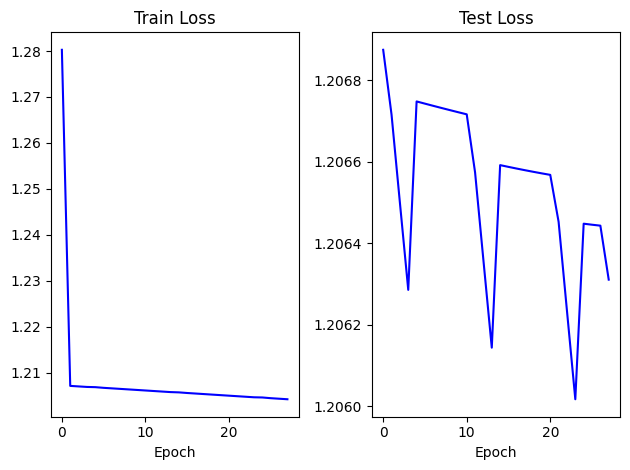

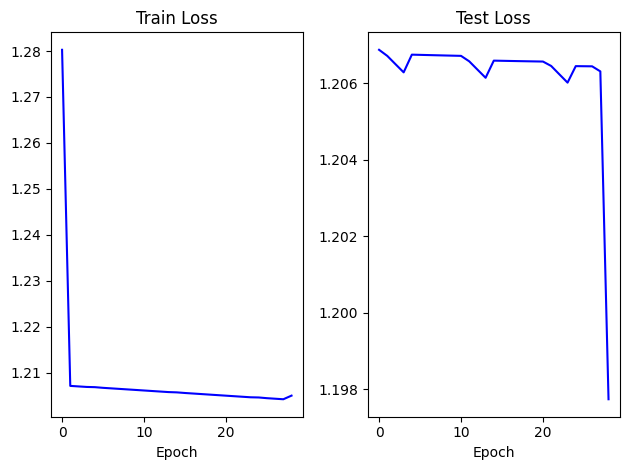

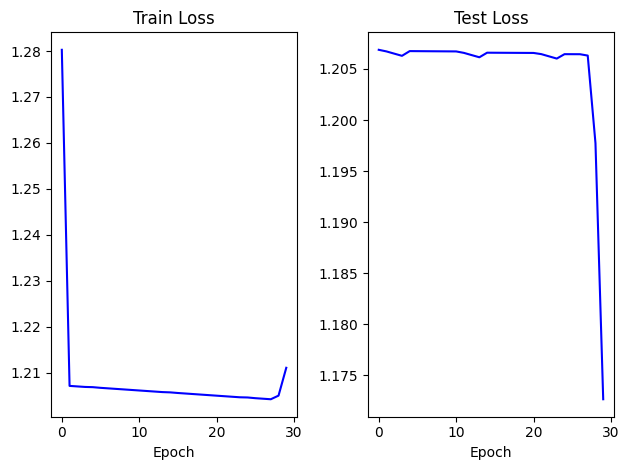

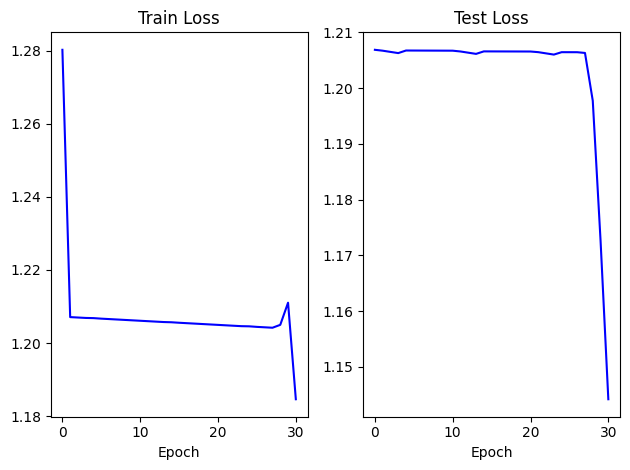

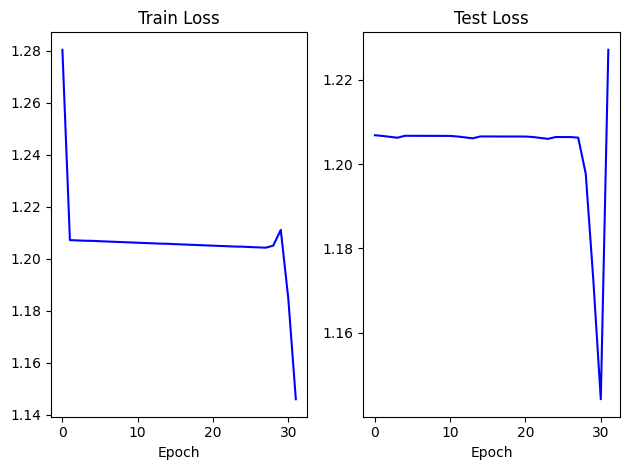

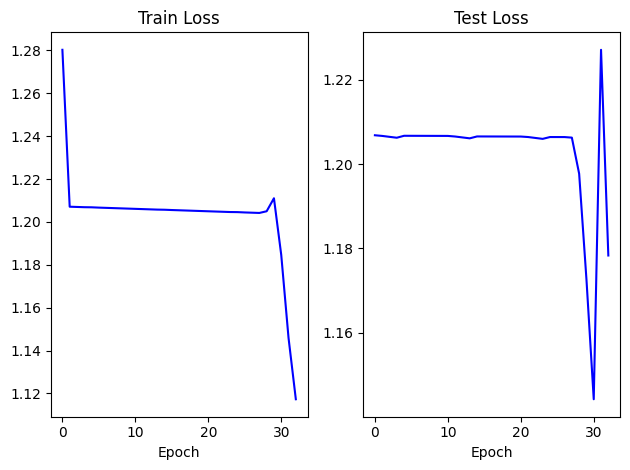

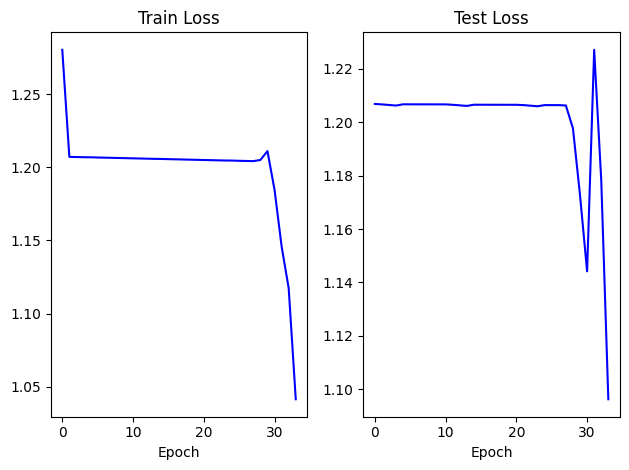

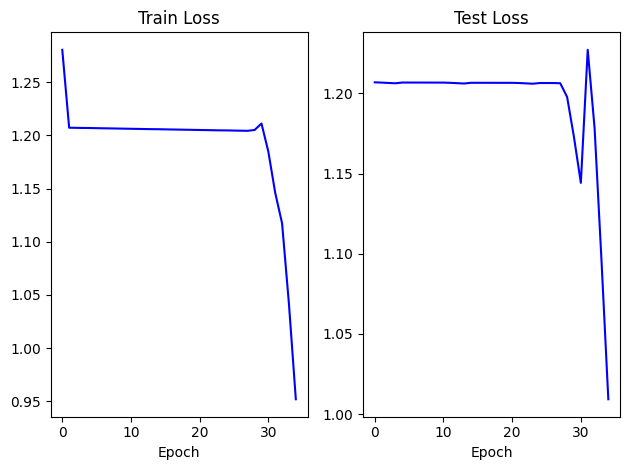

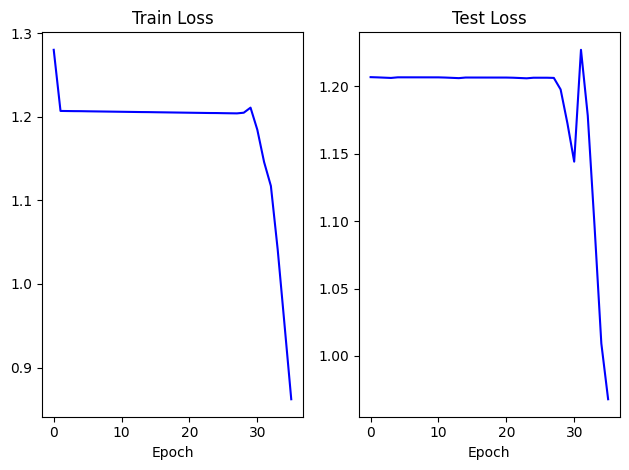

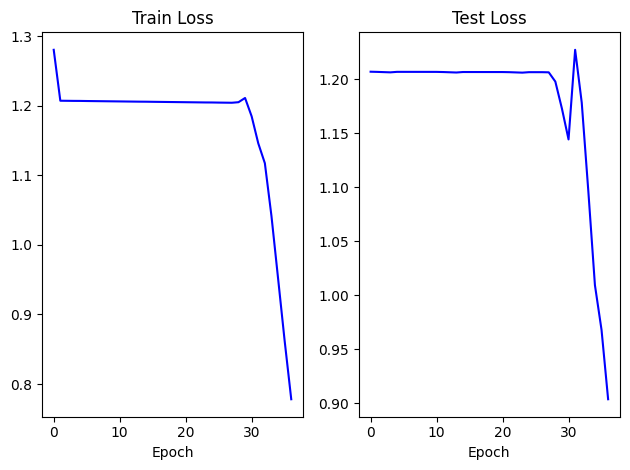

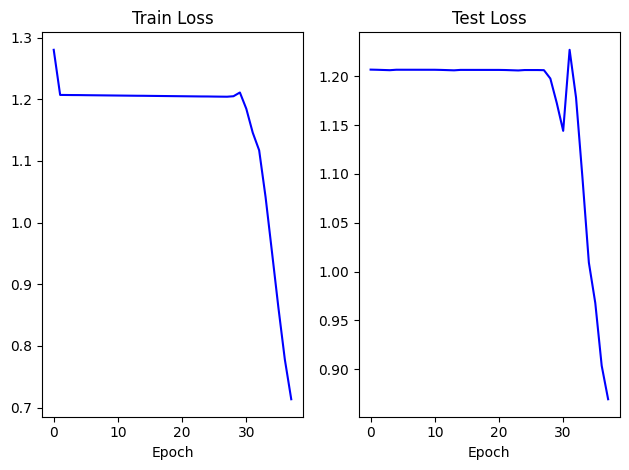

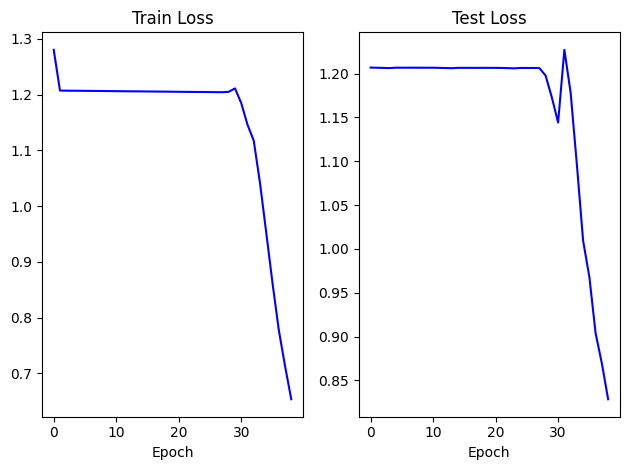

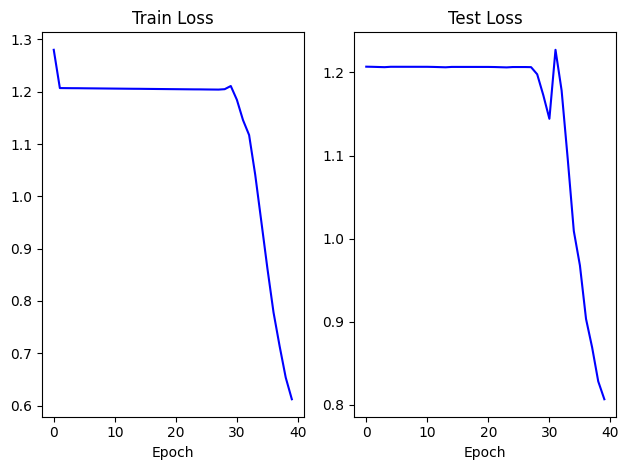

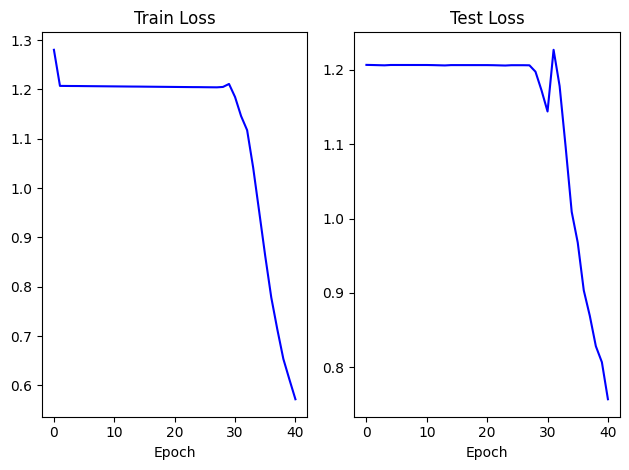

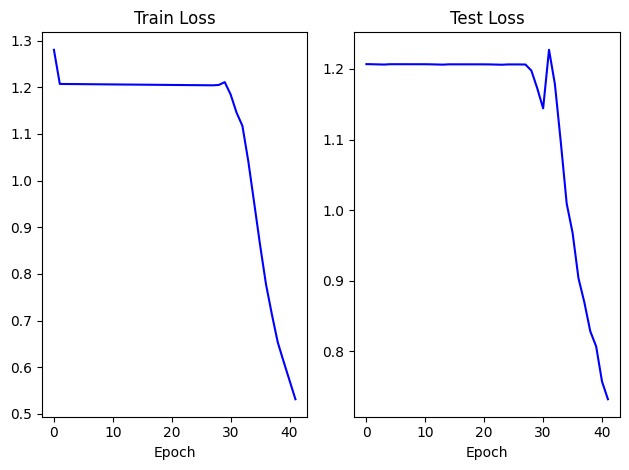

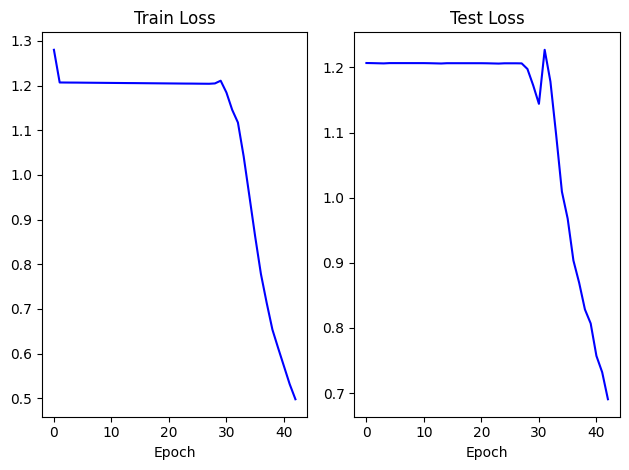

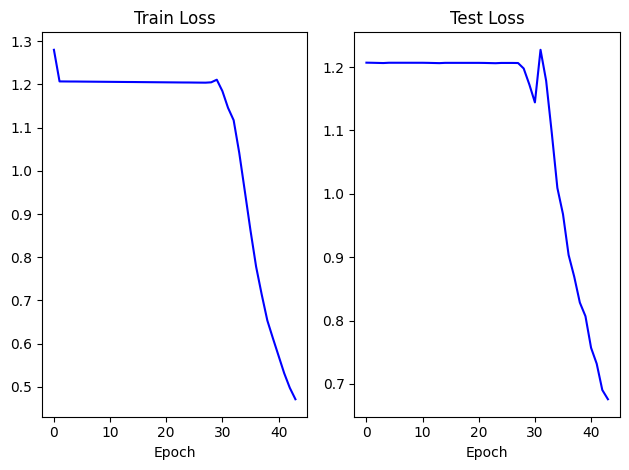

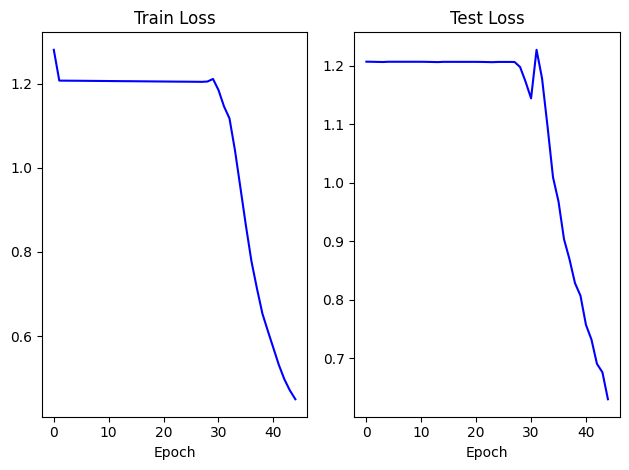

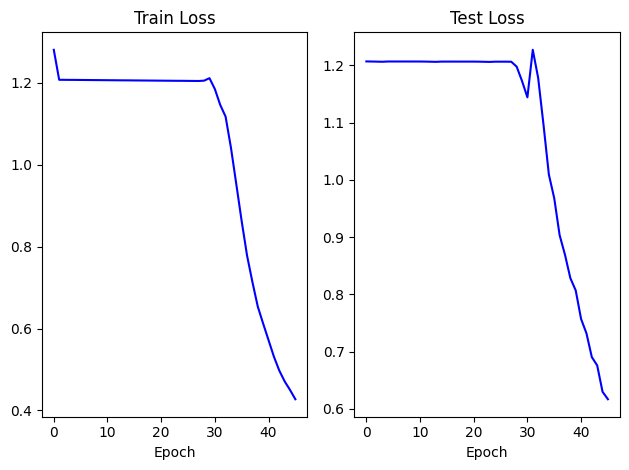

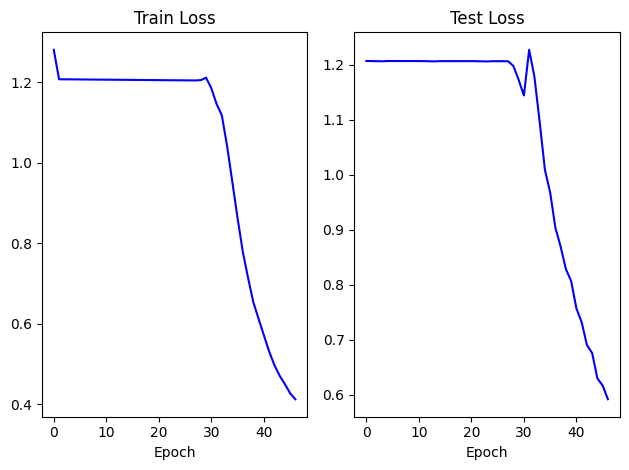

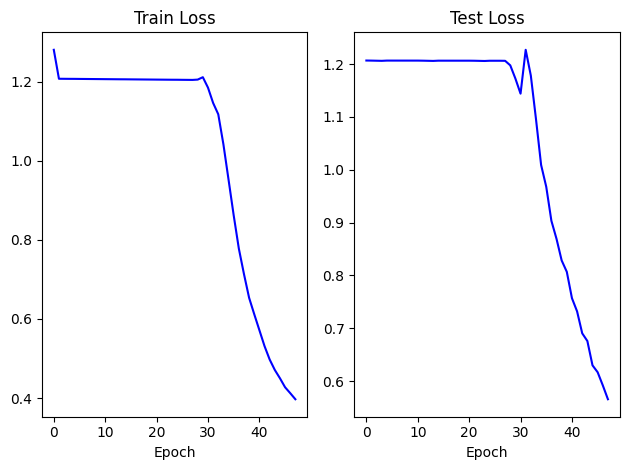

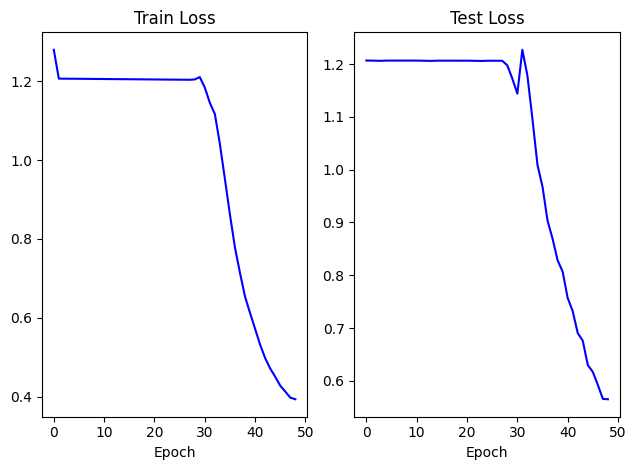

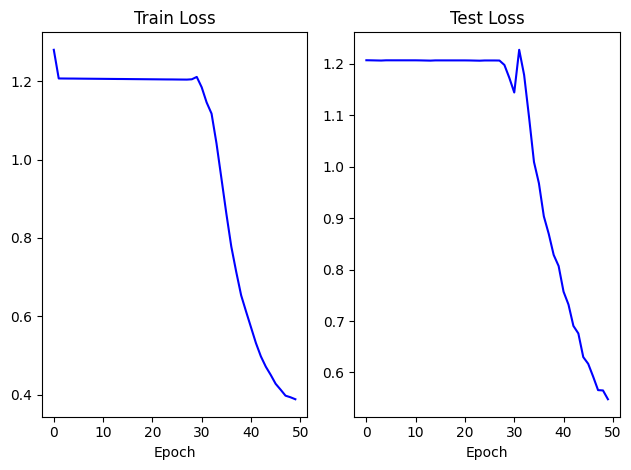

In [16]:
Loss_train = np.zeros(EPOCHS)
Loss_test = np.zeros(EPOCHS)
num_train = len(X_train)
num_test = len(X_test)

for epoch in range(EPOCHS):
    output_train = np.zeros((num_train, num_classes))
    error_train = np.zeros(num_train)
    
    for i in range(num_train):
        # Forward Pass
        input_vec = X_train[i, :].reshape(-1,1)
        NET1 = np.dot(W1, input_vec) + b1
        O1 = F1(NET1)
        NET2 = np.dot(W2, O1) + b2
        O2 = F2(NET2)
        NET3 = np.dot(W3, O2) + b3
        O3 = F3(NET3)
        NET4 = np.dot(W4, O3) + b4
        O4 = F4(NET4)
        Z = softmax(O4)
        
        output_train[i] = Z.reshape(-1)
        error_train[i] = cross_entropy(Y_train_one_hot[i], output_train[i])

        # Backward Pass
        e = -cross_entropy_derivative(Y_train_one_hot[i], output_train[i]).reshape(1,-1)
        DF1 = np.diagflat(dF1(NET1))
        DF2 = np.diagflat(dF2(NET2))
        DF3 = np.diagflat(dF3(NET3))
        DF4 = np.diagflat(dF4(NET4))

        # Calculate gradients
        grad_W4 = ETA_4 * np.dot(np.dot(e, softmax_derivative(O4)), DF4).T @ O3.reshape(1,-1)
        grad_W3 = ETA_3 * np.dot(np.dot(np.dot(e, softmax_derivative(O4)), DF4) @ W4, DF3).T @ O2.reshape(1,-1)
        grad_W2 = ETA_2 * np.dot(np.dot(np.dot(np.dot(e, softmax_derivative(O4)), DF4) @ W4, DF3) @ W3, DF2).T @ O1.reshape(1,-1)
        grad_W1 = ETA_1 * np.dot(np.dot(np.dot(np.dot(np.dot(e, softmax_derivative(O4)), DF4) @ W4, DF3) @ W3, DF2) @ W2, DF1).T @ input_vec.reshape(1,-1)

        if TRAIN_BIAS:
            grad_b4 = ETA_4 * np.dot(e, softmax_derivative(O4)) @ DF4
            grad_b3 = ETA_3 * np.dot(np.dot(e, softmax_derivative(O4)), DF4) @ W4 @ DF3
            grad_b2 = ETA_2 * np.dot(np.dot(np.dot(e, softmax_derivative(O4)), DF4) @ W4, DF3) @ W3 @ DF2
            grad_b1 = ETA_1 * np.dot(np.dot(np.dot(np.dot(e, softmax_derivative(O4)), DF4) @ W4, DF3) @ W3, DF2) @ W2 @ DF1

        # Update weights
        W1 += grad_W1
        W2 += grad_W2
        W3 += grad_W3
        W4 += grad_W4
        if TRAIN_BIAS:
            b1 += grad_b1.T
            b2 += grad_b2.T
            b3 += grad_b3.T
            b4 += grad_b4.T

    Loss_train[epoch] = np.mean(np.square(error_train))

    # Test
    output_test = np.zeros((num_test, num_classes))
    error_test = np.zeros(num_test)
    
    for i in range(num_test):
        input_vec = X_test[i, :].reshape(-1,1)
        NET1 = np.dot(W1, input_vec) + b1
        O1 = F1(NET1)
        NET2 = np.dot(W2, O1) + b2
        O2 = F2(NET2)
        NET3 = np.dot(W3, O2) + b3
        O3 = F3(NET3)
        NET4 = np.dot(W4, O3) + b4
        O4 = F4(NET4)
        Z = softmax(O4)
        
        output_test[i] = Z.reshape(-1)
        error_test[i] = cross_entropy(Y_test_one_hot[i], output_test[i])

    Loss_test[epoch] = np.mean(np.square(error_test))
    
    plot_loss(epoch, Loss_train, Loss_test)

### Training and test loss and accuracy

In [17]:
train_accuracy = np.mean(np.argmax(output_train, axis=1) == np.argmax(Y_train_one_hot, axis=1))
test_accuracy = np.mean(np.argmax(output_test, axis=1) == np.argmax(Y_test_one_hot, axis=1))

In [18]:
print(f"Final Train Loss: {Loss_train[-1]:.4f}")
print(f"Final Test Loss: {Loss_test[-1]:.4f}")
print(f"Final Train Accuracy: {train_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Train Loss: 0.3880
Final Test Loss: 0.5479
Final Train Accuracy: 0.8120
Final Test Accuracy: 0.6667


### Confusion Matrix

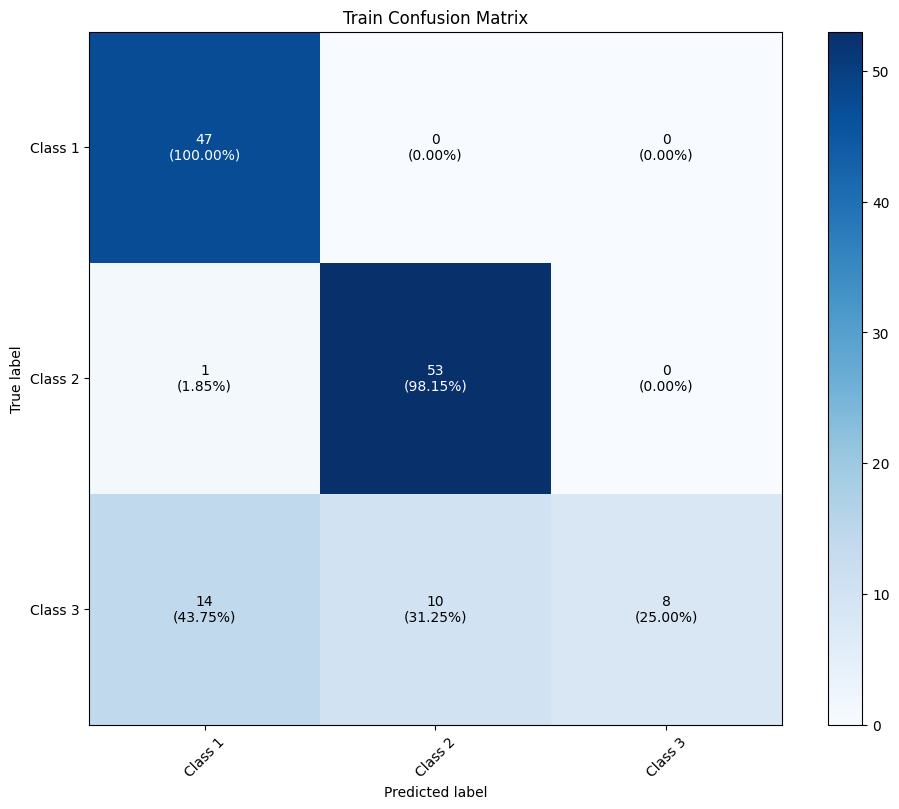

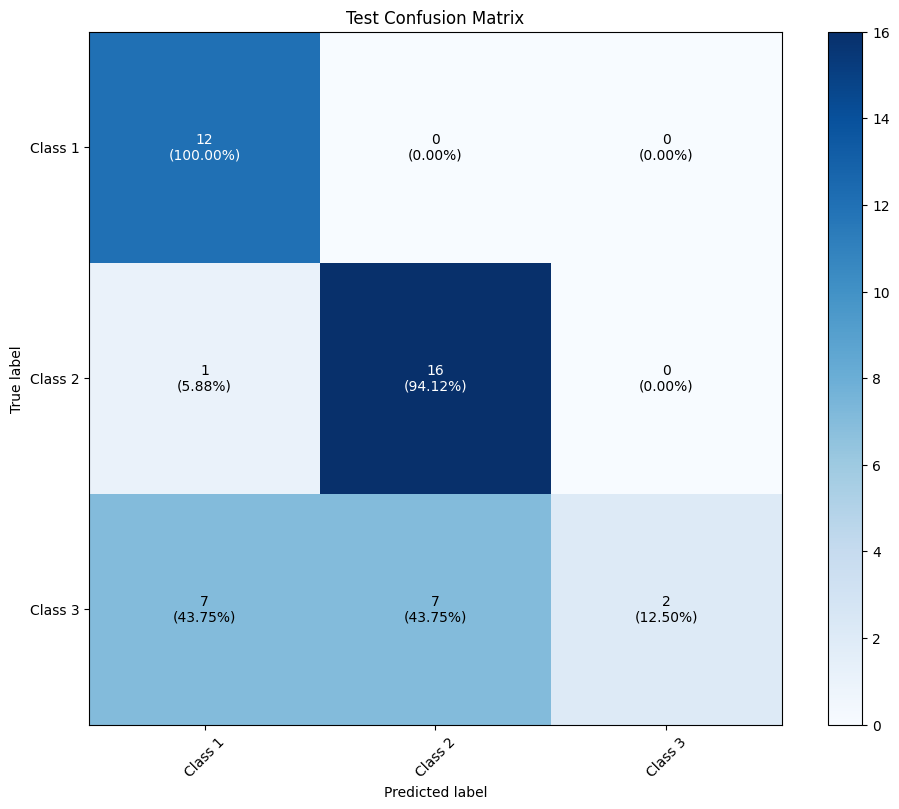

In [19]:
plt.show()
plot_confusion_matrix(Y_train_one_hot, output_train, ['Class 1', 'Class 2', 'Class 3'], 'Train Confusion Matrix')
plot_confusion_matrix(Y_test_one_hot, output_test, ['Class 1', 'Class 2', 'Class 3'], 'Test Confusion Matrix')